In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import warnings
warnings.filterwarnings('ignore')

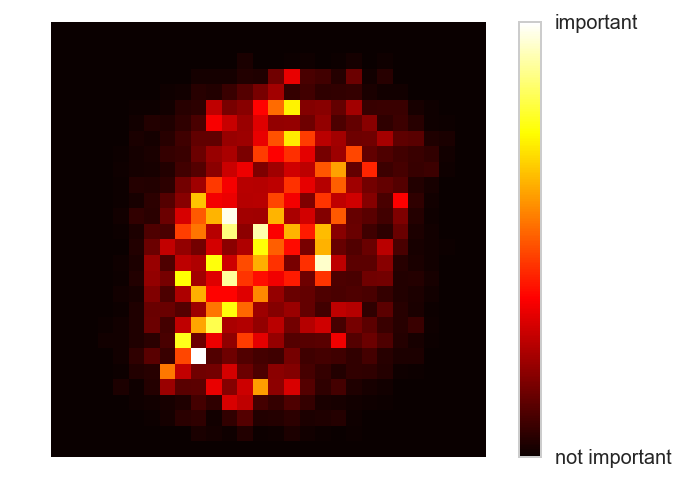

In [10]:
from sklearn.datasets import fetch_mldata
from sklearn.ensemble import RandomForestClassifier

mnist = fetch_mldata('MNIST original')
rnd_clf = RandomForestClassifier(random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.hot,
               interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['not important', 'important'])
 
plt.show()

1. 많은 머신러닝 문제는 훈련 샘플의 특성은 수천에서 수백만개가 될 수 있습니다. 이는 훈련을 느리게 할 뿐만 아니라, 좋은 솔루션을 찾기 어렵게 만듭니다. 이를 차원의 저주라 합니다.
    
1. MNIST문제에서 외곽에 위치한 픽셀은 흰색으로 완전히 제거해도 숫자 분류 작업에 영향을 주지 않습니다. 게다가 인접한 두 픽셀은 연관이 클 가능성이 있기에 두 픽셀을 하나의 픽셀로 합치더라도 잃는 정보는 많지 않을 것입니다.

1. 차원을 축소시킬 경우 일부 정보가 유실됩니다. 훈련속도는 빨라지겠지만 모델의 성능은 나빠질 가능성이 있습니다. 그러므로 차원 축소 전 훈련이 너무 느린지 확인해야 합니다.

1. 훈련속도를 높이는 것 외에 차원축소는 데이터 시각화에 아주 유용합니다. 그래프로 표현하여 군집같은 시각적인 패턴을 감지 할 수 있습니다.

## 8.1 차원의 저주

## 8.2 차원 축소를 위한 접근 방법

### 8.2.1 투영

In [22]:
from sklearn.decomposition import PCA
np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

pca = PCA(n_components = 2)
X2D = pca.fit_transform(X)

In [23]:
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
        
axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])

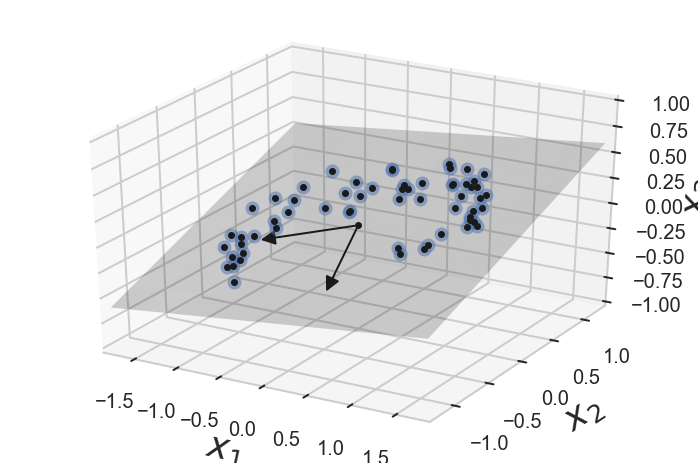

In [26]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X[X[:, 2] > X[:, 2]]
X3D_below = X[X[:, 2] <= X[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X[i, 2] > X[i, 2]:
        ax.plot([X[i][0], X[i][0]], [X[i][1], X[i][1]], [X[i][2], X[i][2]], "k-")
    else:
        ax.plot([X[i][0], X[i][0]], [X[i][1], X[i][1]], [X[i][2], X[i][2]], "k-", color="#505050")
    
ax.plot(X[:, 0], X[:, 1], X[:, 2], "k+")
ax.plot(X[:, 0], X[:, 1], X[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=4)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

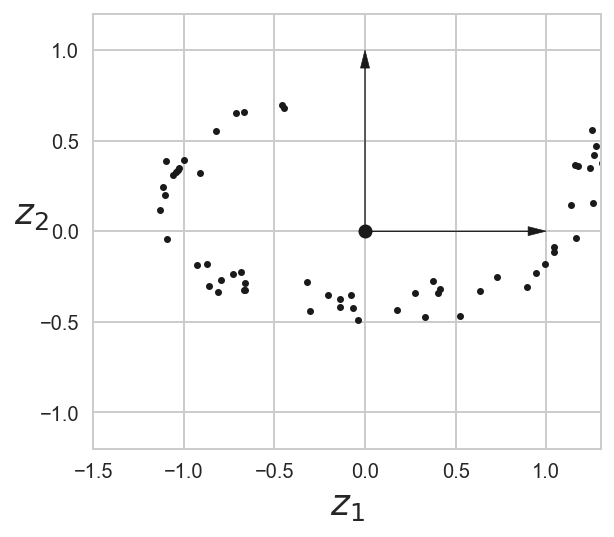

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True) 

훈련 샘플이 무돈 차원에 걸쳐 균일하게 퍼져 있지 않습니다. 대다수 특성은 거의 변화가 없는반면(특히 MNIST) 다른 특성들은 서로 강하게 연관되어 있습니다. 결과적으로 모든 훈련 샘플이 사실 고차원 공간 안의 저차원 부분공간에 위치합니다

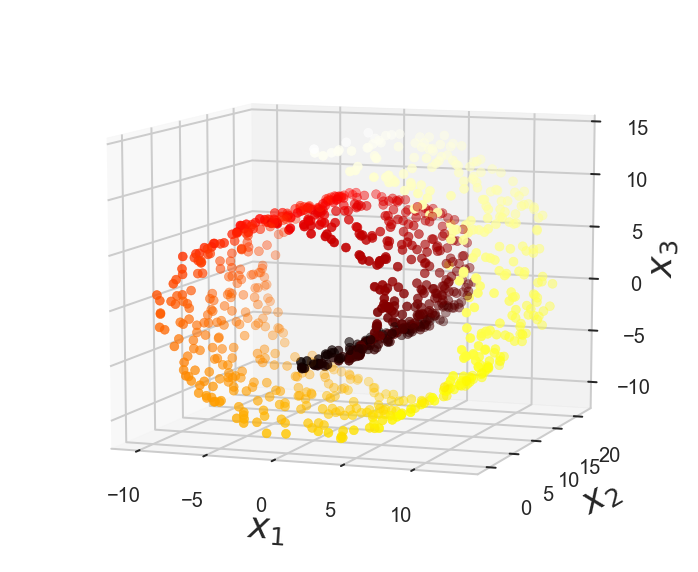

In [28]:
from sklearn.datasets import make_swiss_roll
X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18, labelpad=7)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=7)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

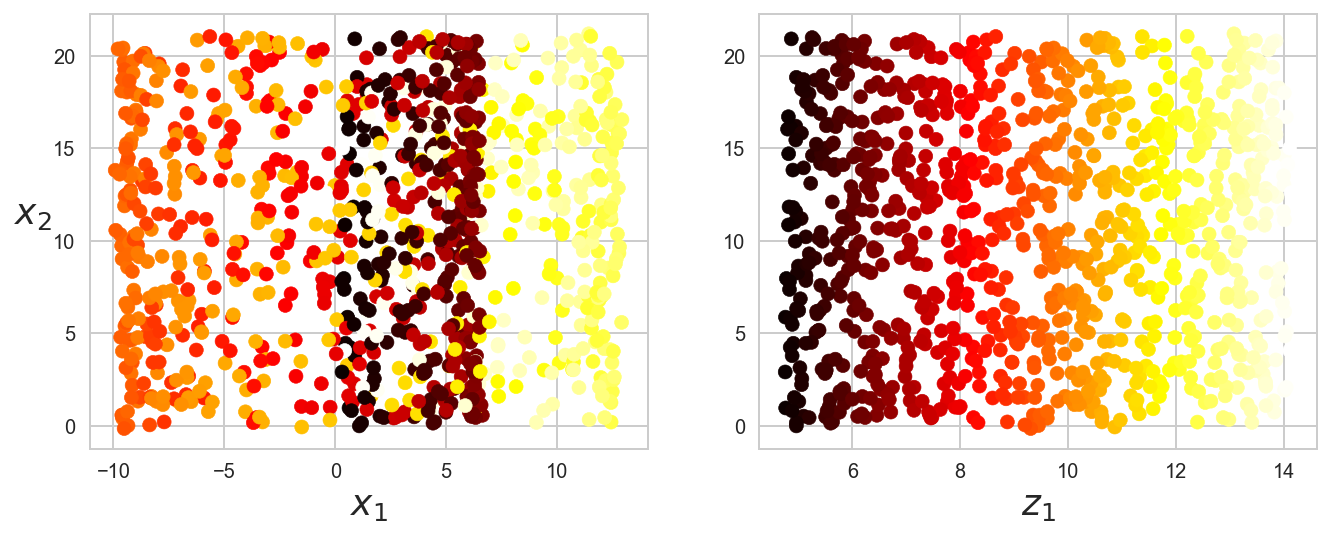

In [31]:
plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot) 
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0, labelpad=10)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot) 
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

그냥 평면에 투영시키면 층이 서로 뭉개지기ㅔ 됩니다. 우리가 원하는 바는 오른쪽 그림처럼 스위스 롤을 펼친 데이터셋을 얻는 것입니다

### 8.2.2 매니폴드 학습

2D 매니폴드는 고차원 공간에서 휘어지거나 뒤틀린 2D모양입니다. 더 일반적으로 d차원 매니폴드는 국부적으로 **d차원 초평면**으로 보일 수 있는 **n차원 공간의 일부** 입니다. (d < n)

많은 차원축소 알고리즘이 훈련 샘플이 놓여 있는 매니폴드를 모델링하는 식으로 작동합니다.
이를 매니폴드 학습이라고 합니다. 
대부분 실제 고차원 데이터셋이 더 낮은 저차원 매니폴드에 가깝게 놓여 있다는 매니폴드 가정또는 매니폴드 가설에 근거합니다.

훈련시키기 전 차원을 감소시키면 훈련 속도는 빨라지지만 항상 더 나은 솔루션이 되는 것은 아닙니다.

## 8.3 PCA
주성분 분석(principal componet analysis) 가장 인기있는 축소 알고리즘입니다. 먼저 데이터에 가장 가까운 초평면을 정의한 다음 데이터를 이 평면에 투영시킵니다.

### 8.3.1 분산 보존

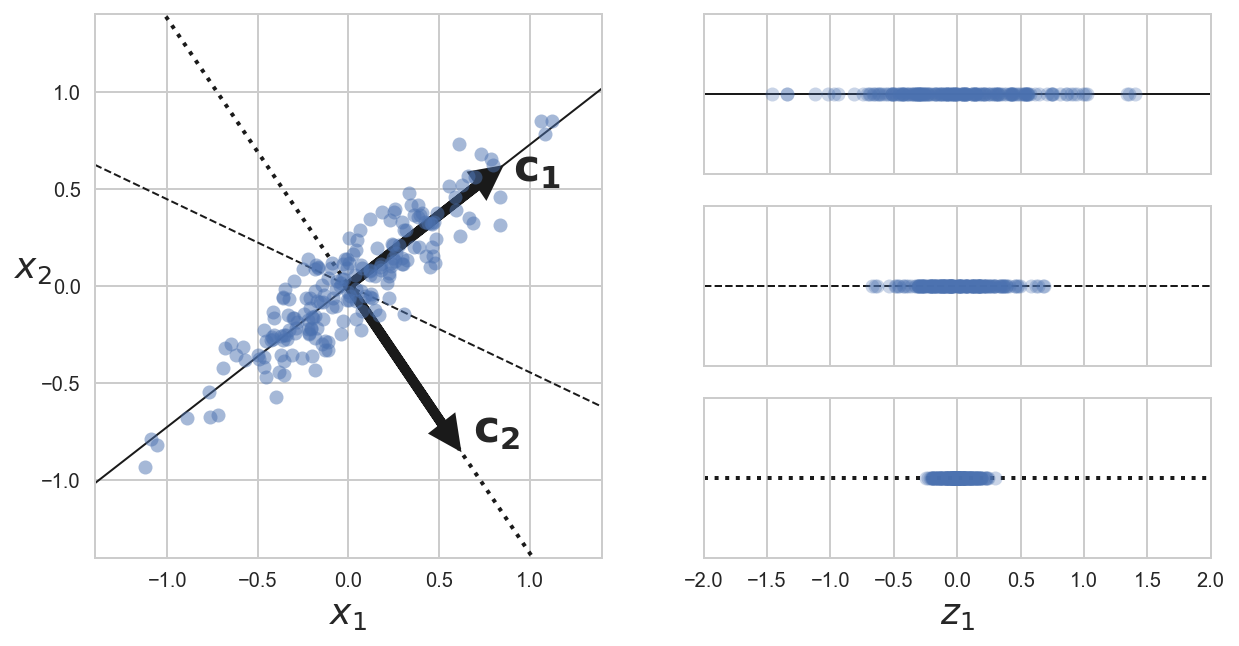

In [36]:
angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(10, 5))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)
plt.show()

저차원의 초평면에 훈련세트를 투영하기 전에 먼저 올바른 초평면을 선택해야 합니다. 

분산이 최대로 보존되는 축을 선택하는 것이 정보가 가장 적게 손실되므로 합리적인 방법입니다. 다른 방식으로 설명하면 원본 데이터셋과 투영된 것 사이의 평균 제곱 거리를 최소화하는 축입니다.

### 8.3.2 주성분

i번째 축을 정의하는 단위 벡터를 i번째 주성분이라고 부릅니다. 위의 그림에서 c1, c2가 주성분입니다.

주성분을 찾는 방법은 특잇값분해를 이용하여 행렬 X를 $ U \cdot \sum \cdot V^T $로 분해할 수 있습니다. 여기서 찾고자 하는 모든 주성분은 V입니다.

In [40]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt.T[:, 0]
c2 = Vt.T[:, 1]

In [41]:
m, n = X.shape

S = np.zeros(X_centered.shape)
S[:n, :n] = np.diag(s) 
np.allclose(X_centered, U.dot(S).dot(Vt))

True

In [42]:
W2 = Vt.T[:, :2]
X2D = X_centered.dot(W2) 
X2D_using_svd = X2D

[-2, 2, -1, 1]

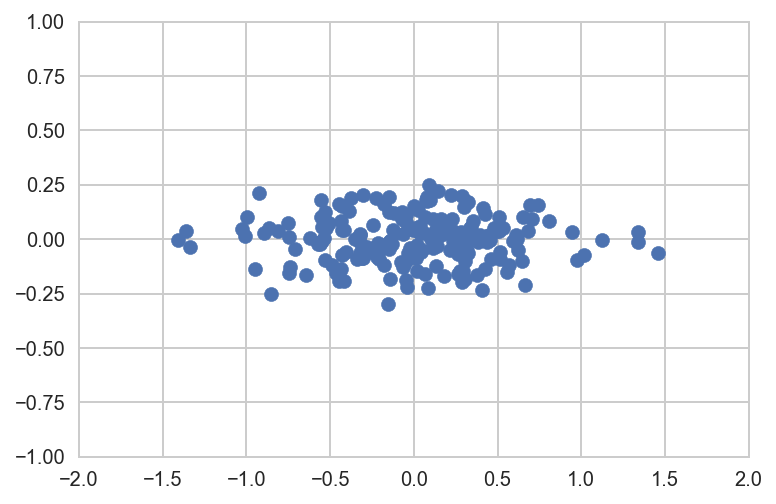

In [45]:
plt.scatter(X2D_using_svd[:, 0], X2D_using_svd[:, 1])
plt.axis([-2, 2, -1, 1])